In [155]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [156]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [157]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [158]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [159]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [207]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0, st="f(0, 0..., 0)"):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f"Theoretical value ({function_name}):{st} = {c}\n")
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [208]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [209]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.99193967 -0.98538453]
The function value of pqbest:		2.0098842650221656
Algorithm running time:			3.655104160308838 s


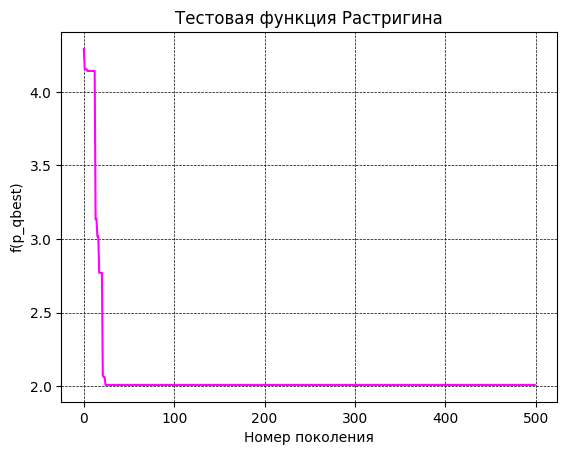

------------------------TEST NUMBER: 2------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.0447957   2.01299641]
The function value of pqbest:		4.480973290097019
Algorithm running time:			0.0399782657623291 s


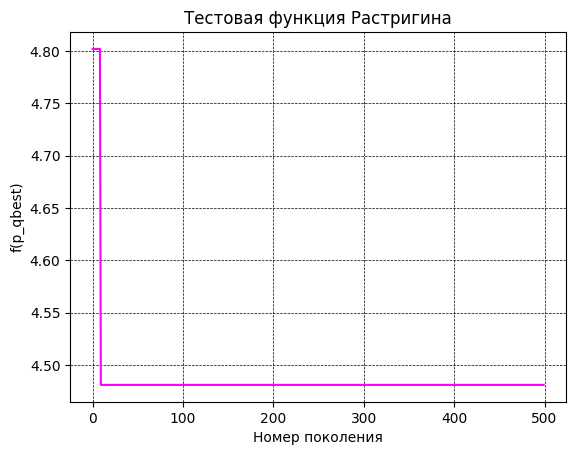

------------------------TEST NUMBER: 3------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-1.00212201  0.01237232]
The function value of pqbest:		1.035490862923357
Algorithm running time:			0.04797983169555664 s


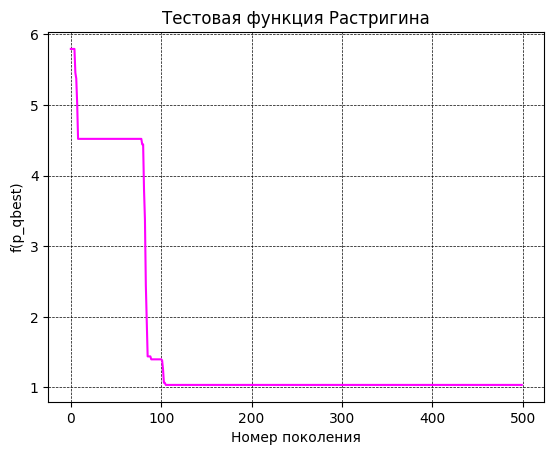

------------------------TEST NUMBER: 4------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 1.01067999 -0.99121149]
The function value of pqbest:		2.0417230517357936
Algorithm running time:			0.047998905181884766 s


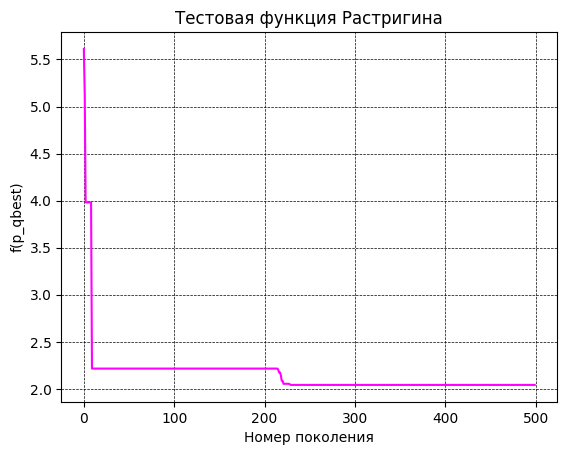

------------------------TEST NUMBER: 5------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 1.03312079 -0.00893123]
The function value of pqbest:		1.2989157538591272
Algorithm running time:			0.047855377197265625 s


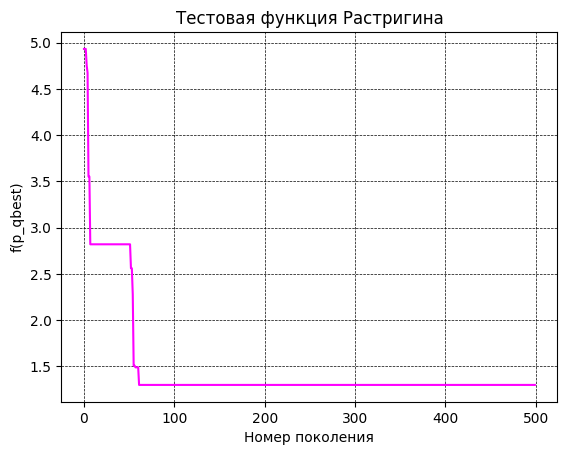

------------------------TEST NUMBER: 6------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.04289927 -1.02252006]
The function value of pqbest:		1.5084046480897548
Algorithm running time:			0.04799151420593262 s


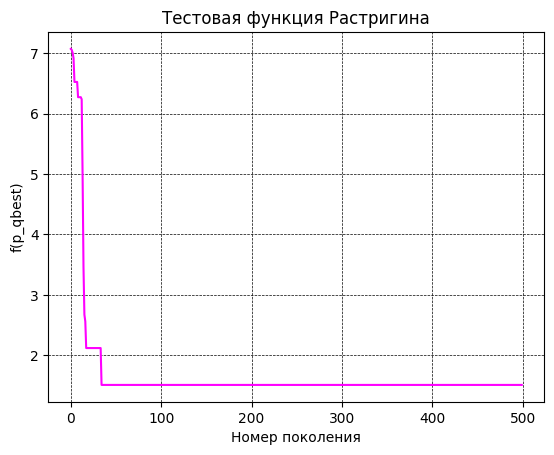

------------------------TEST NUMBER: 7------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.99966909 0.97956549]
The function value of pqbest:		2.0412201701042356
Algorithm running time:			0.04800868034362793 s


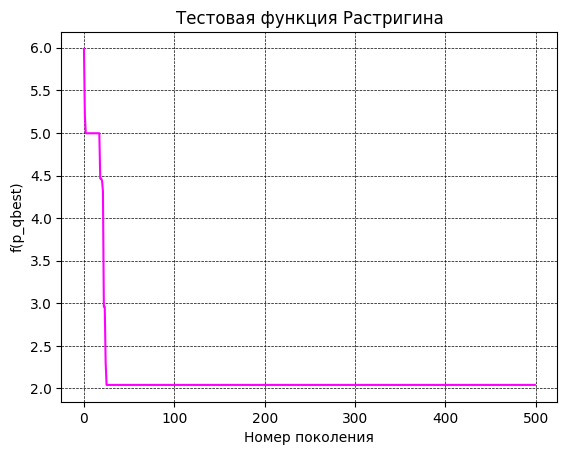

------------------------TEST NUMBER: 8------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.01134743 -0.98317045]
The function value of pqbest:		1.0480152075503852
Algorithm running time:			0.05598187446594238 s


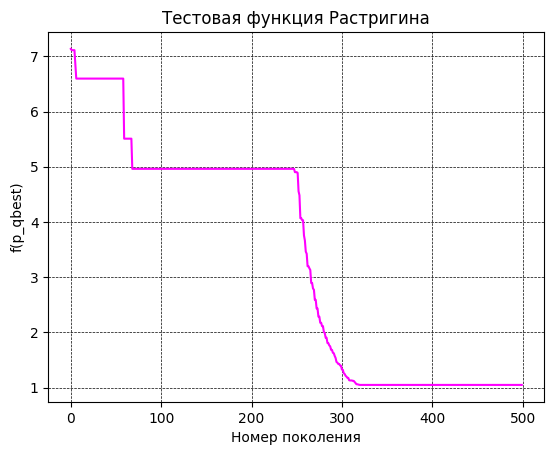

------------------------TEST NUMBER: 9------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.95236363 -0.04200011]
The function value of pqbest:		1.6995386728350041
Algorithm running time:			0.06399250030517578 s


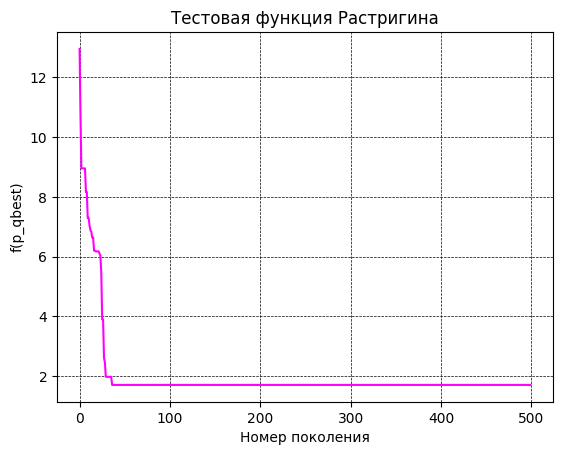

------------------------TEST NUMBER: 10------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.06056653 -1.09224299]
The function value of pqbest:		3.545132378726038
Algorithm running time:			0.03998970985412598 s


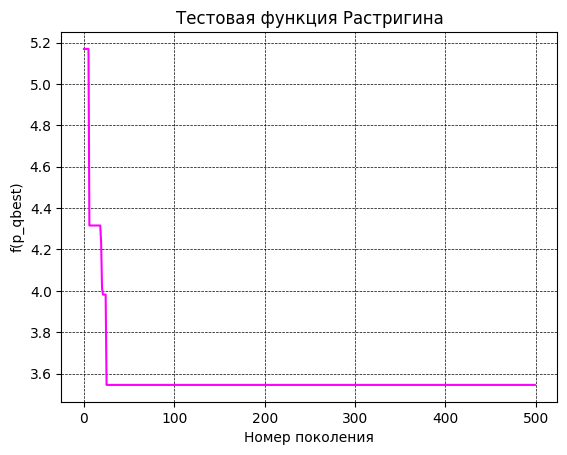

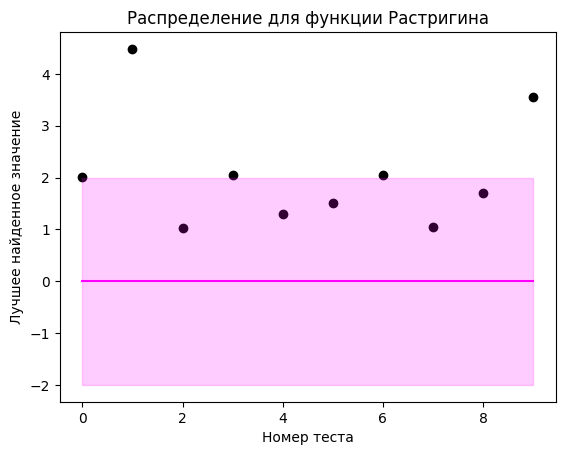

In [210]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [211]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [212]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.05831025  0.22093824]
The function value of pqbest:		1.6077626066121056
Algorithm running time:			3.6624221801757812 s


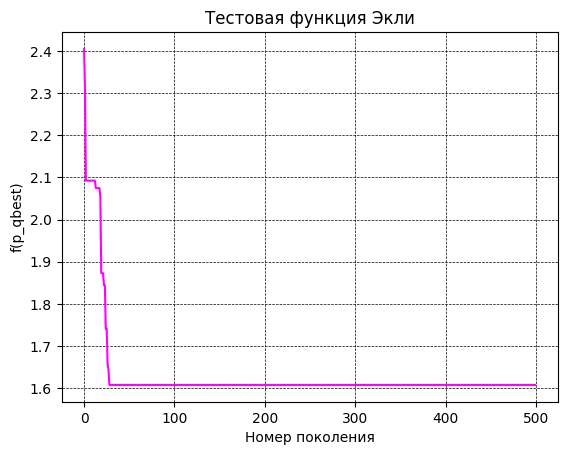

------------------------TEST NUMBER: 2------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[ 1.07956191 -0.00545436]
The function value of pqbest:		2.9939112927910934
Algorithm running time:			0.04800295829772949 s


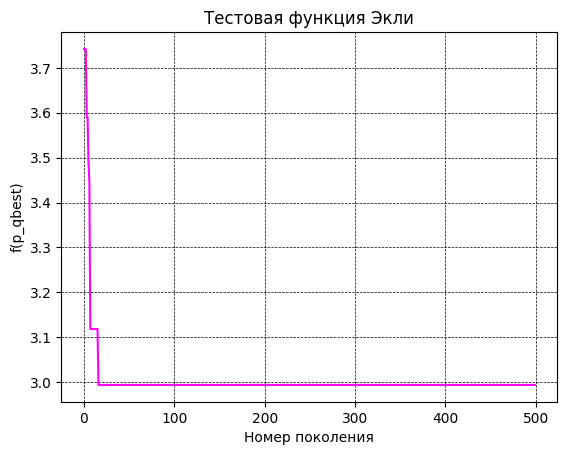

------------------------TEST NUMBER: 3------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[0.00018051 0.00495876]
The function value of pqbest:		0.01469027886422225
Algorithm running time:			0.05600261688232422 s


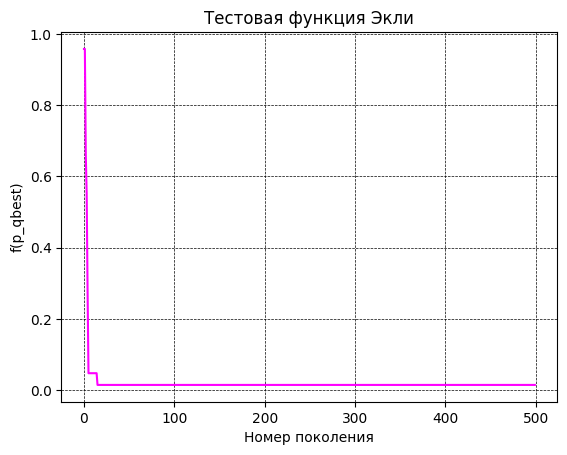

------------------------TEST NUMBER: 4------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.18795263  0.07722285]
The function value of pqbest:		1.4028684974211316
Algorithm running time:			0.048029422760009766 s


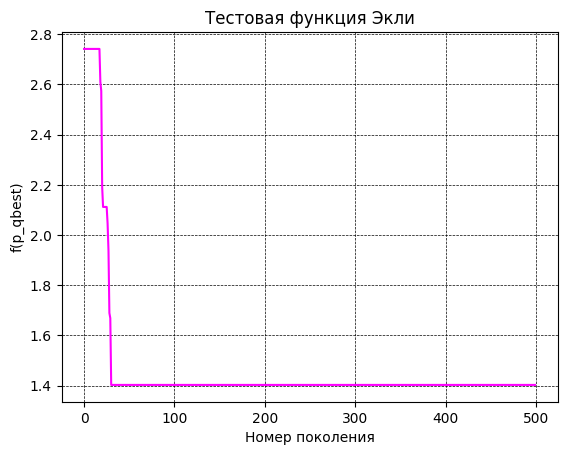

------------------------TEST NUMBER: 5------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.05301153  0.1021216 ]
The function value of pqbest:		0.6468290200458284
Algorithm running time:			0.04799222946166992 s


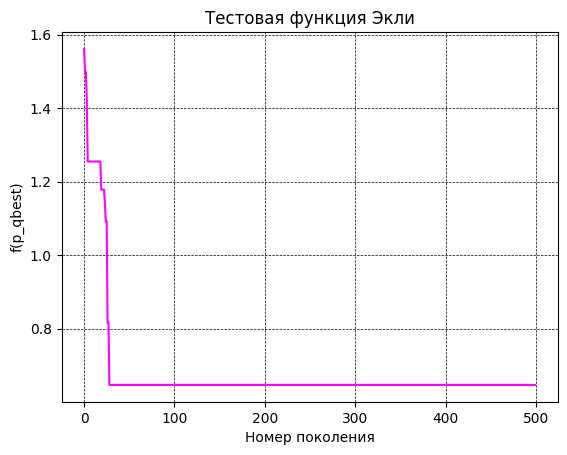

------------------------TEST NUMBER: 6------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[1.02810037 0.03196192]
The function value of pqbest:		2.755622558557235
Algorithm running time:			0.05585885047912598 s


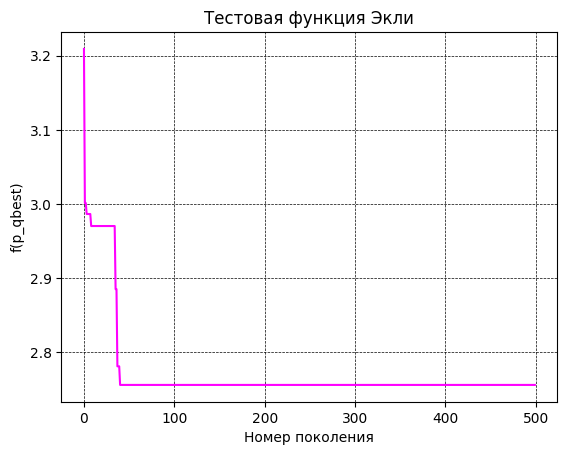

------------------------TEST NUMBER: 7------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[ 0.00070861 -0.00231191]
The function value of pqbest:		0.006995022133505557
Algorithm running time:			0.04800724983215332 s


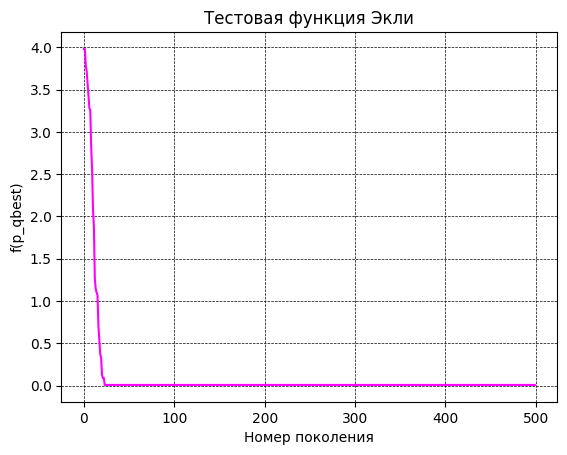

------------------------TEST NUMBER: 8------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.10294055  0.13631819]
The function value of pqbest:		1.1277141620057876
Algorithm running time:			0.05600452423095703 s


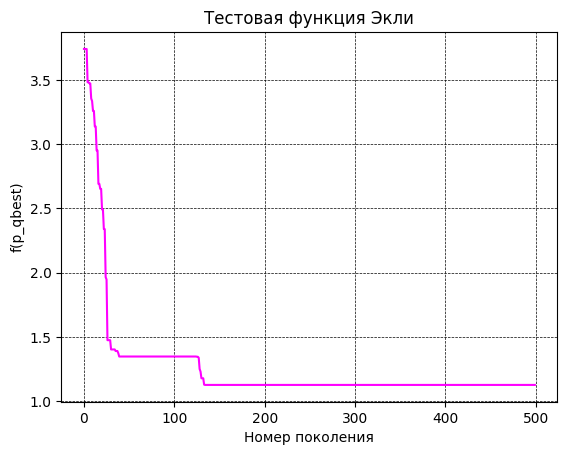

------------------------TEST NUMBER: 9------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[ 0.08795997 -0.10731402]
The function value of pqbest:		0.8451571791351569
Algorithm running time:			0.04913330078125 s


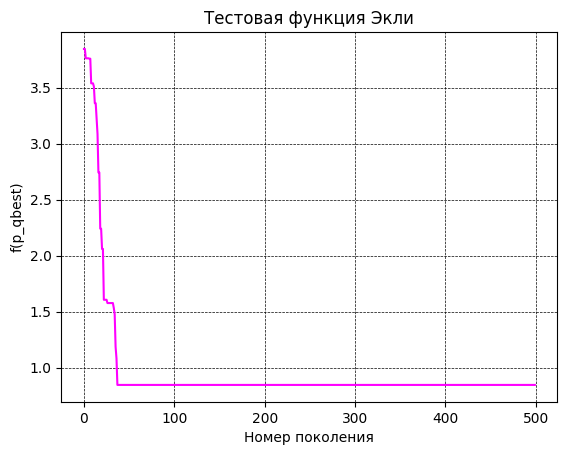

------------------------TEST NUMBER: 10------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-1.16664616  0.04674758]
The function value of pqbest:		3.690196377164863
Algorithm running time:			0.0720055103302002 s


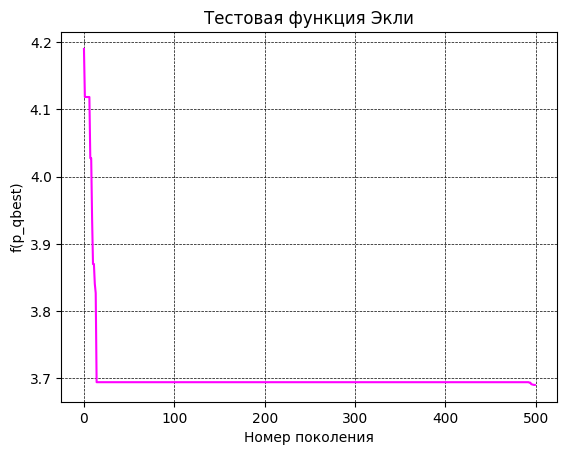

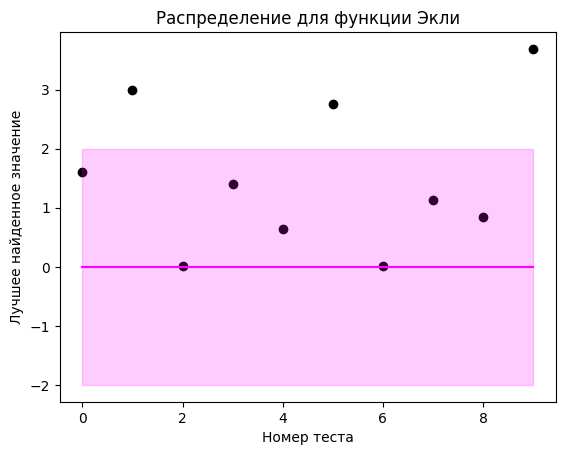

In [213]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(0, 0)")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [214]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [215]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-1, 1, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00662349  0.00737117]
The function value of pqbest:		9.820474606786082e-05
Algorithm running time:			3.728224515914917 s


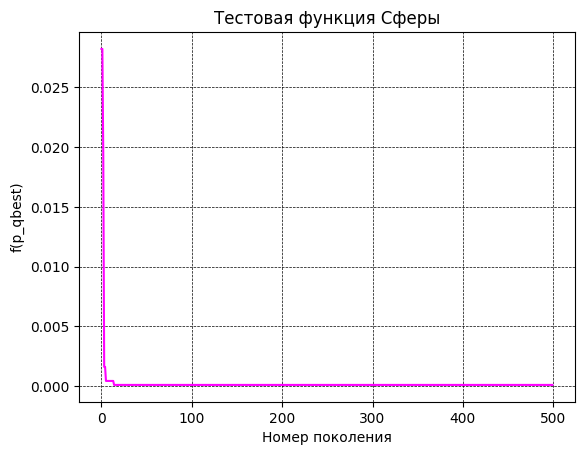

------------------------TEST NUMBER: 2------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.01596713 0.00614785]
The function value of pqbest:		0.0002927453287513582
Algorithm running time:			0.0391993522644043 s


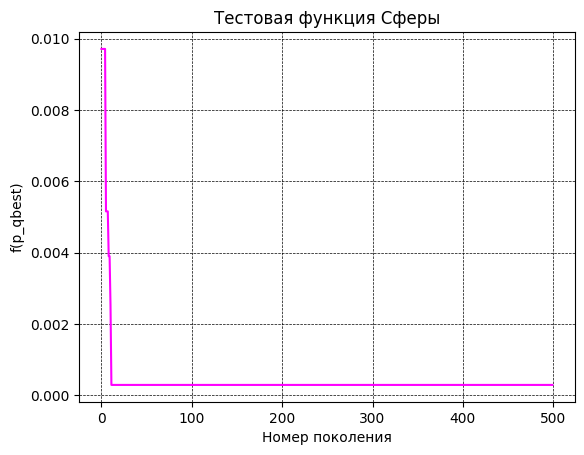

------------------------TEST NUMBER: 3------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00092984 -0.00051213]
The function value of pqbest:		1.126881414473994e-06
Algorithm running time:			0.04779243469238281 s


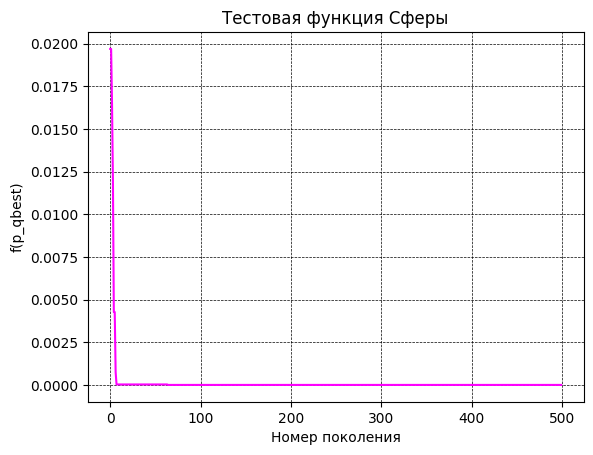

------------------------TEST NUMBER: 4------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.01585908 0.03284025]
The function value of pqbest:		0.0013299925889356961
Algorithm running time:			0.0366976261138916 s


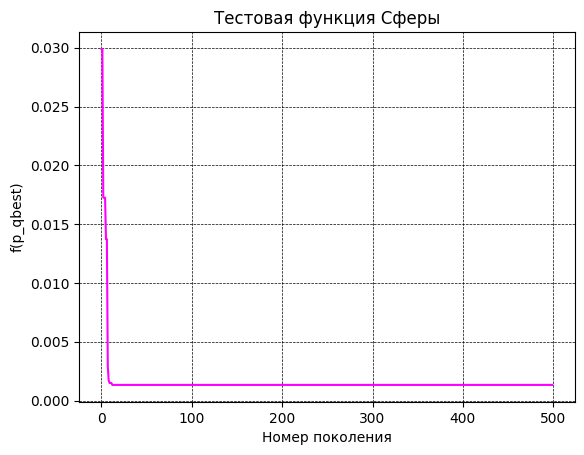

------------------------TEST NUMBER: 5------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00344389 -0.00340452]
The function value of pqbest:		2.34510861540074e-05
Algorithm running time:			0.03997683525085449 s


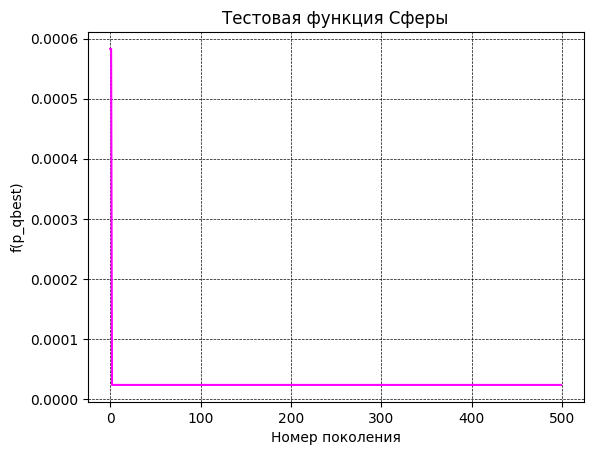

------------------------TEST NUMBER: 6------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00335082 -0.00255695]
The function value of pqbest:		1.7765994182631236e-05
Algorithm running time:			0.03999447822570801 s


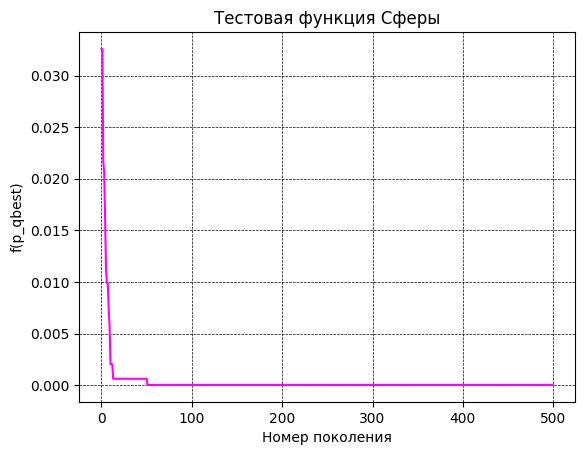

------------------------TEST NUMBER: 7------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.04568637  0.0181638 ]
The function value of pqbest:		0.0024171680800402213
Algorithm running time:			0.05603671073913574 s


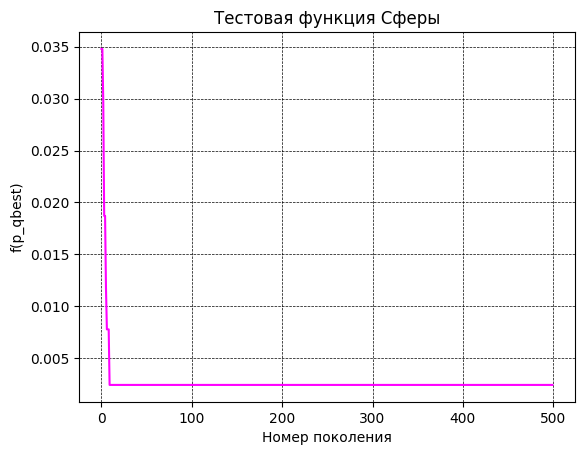

------------------------TEST NUMBER: 8------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.0018235  0.001881 ]
The function value of pqbest:		6.863302508233497e-06
Algorithm running time:			0.04747772216796875 s


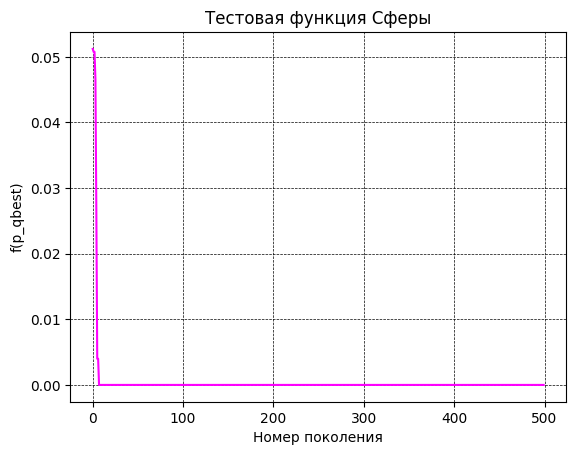

------------------------TEST NUMBER: 9------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00207915 -0.00310074]
The function value of pqbest:		1.3937466144990624e-05
Algorithm running time:			0.039984703063964844 s


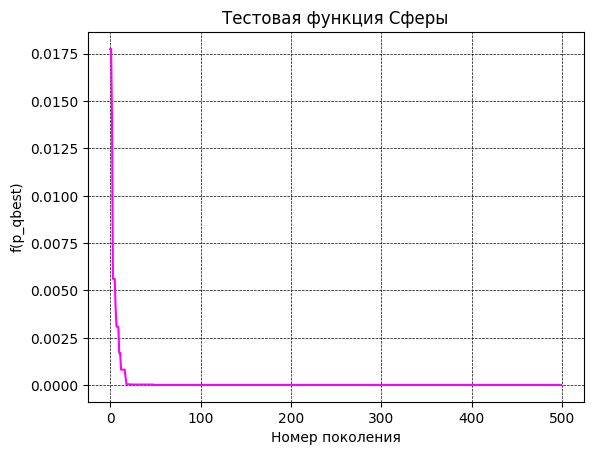

------------------------TEST NUMBER: 10------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.01073643  0.01429127]
The function value of pqbest:		0.0003195114129376127
Algorithm running time:			0.04799842834472656 s


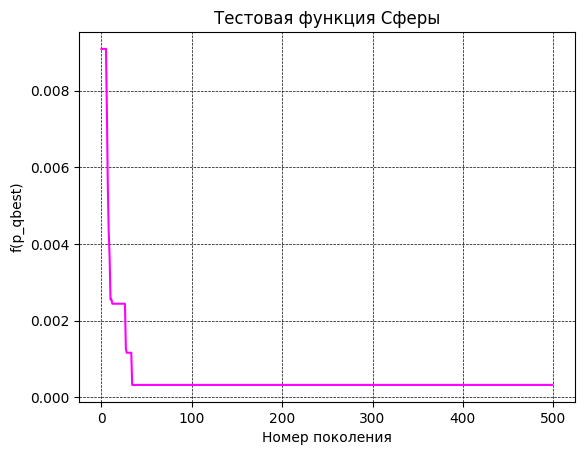

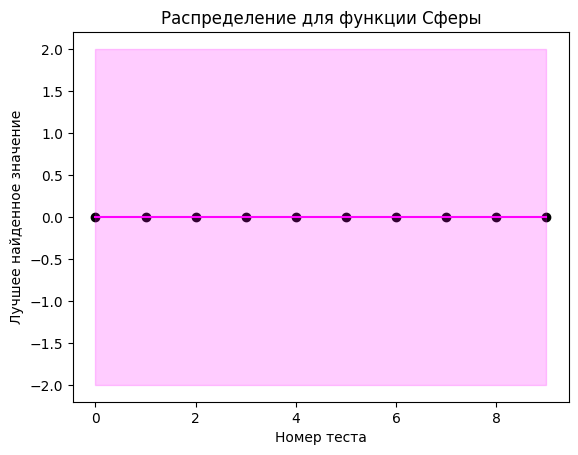

In [216]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [217]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [218]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[-0.33358804  0.12361381]
The function value of pqbest:		1.7936669213792082
Algorithm running time:			3.5920846462249756 s


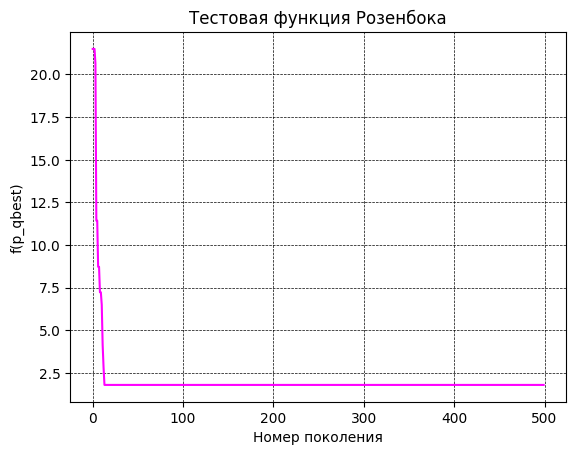

------------------------TEST NUMBER: 2------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.91412733 3.66611707]
The function value of pqbest:		0.836127687085254
Algorithm running time:			0.04000663757324219 s


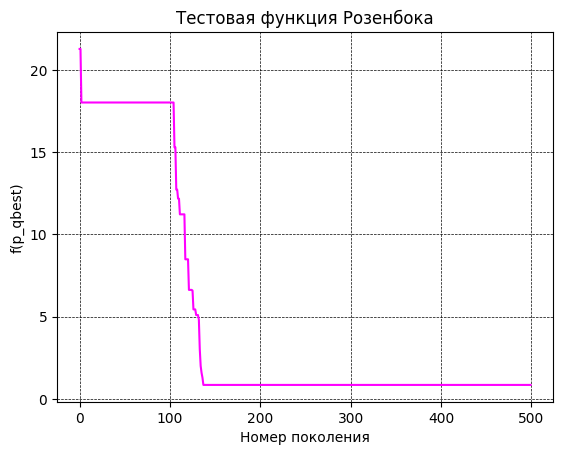

------------------------TEST NUMBER: 3------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[0.60688955 0.37006622]
The function value of pqbest:		0.15484253015443242
Algorithm running time:			0.04798150062561035 s


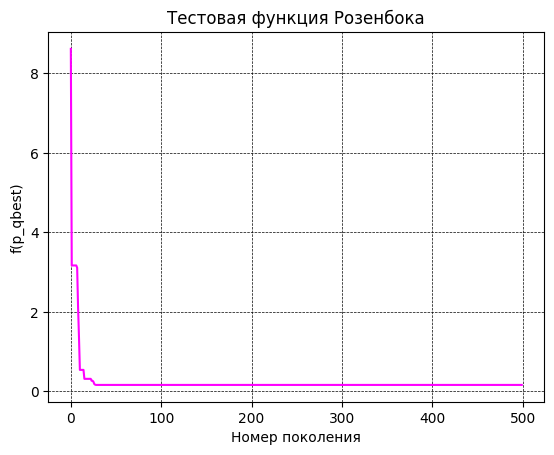

------------------------TEST NUMBER: 4------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.53494519 2.3498879 ]
The function value of pqbest:		0.28997181354183255
Algorithm running time:			0.04000091552734375 s


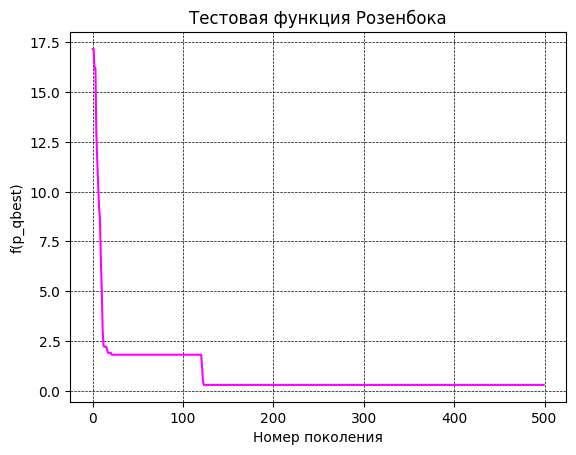

------------------------TEST NUMBER: 5------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[2.36428494 5.5832129 ]
The function value of pqbest:		1.8656696073858137
Algorithm running time:			0.04797077178955078 s


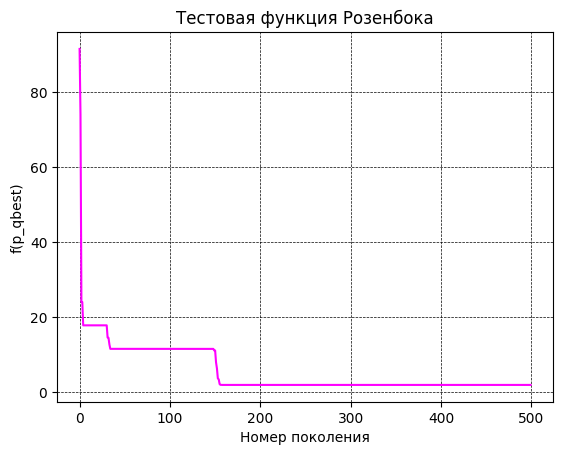

------------------------TEST NUMBER: 6------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.84674136 3.41957843]
The function value of pqbest:		0.7252970963533336
Algorithm running time:			0.04800724983215332 s


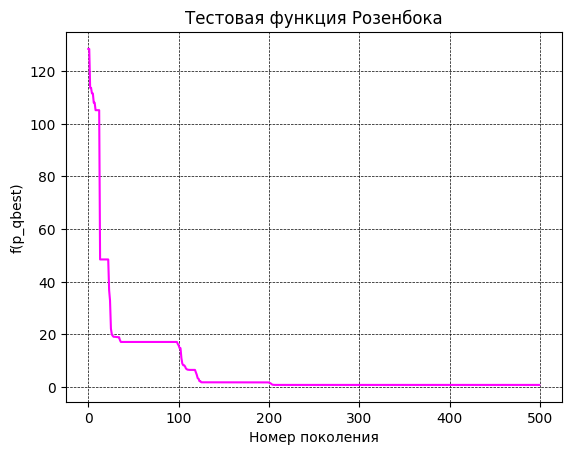

------------------------TEST NUMBER: 7------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[0.35883627 0.1448055 ]
The function value of pqbest:		0.43682560430381145
Algorithm running time:			0.039983510971069336 s


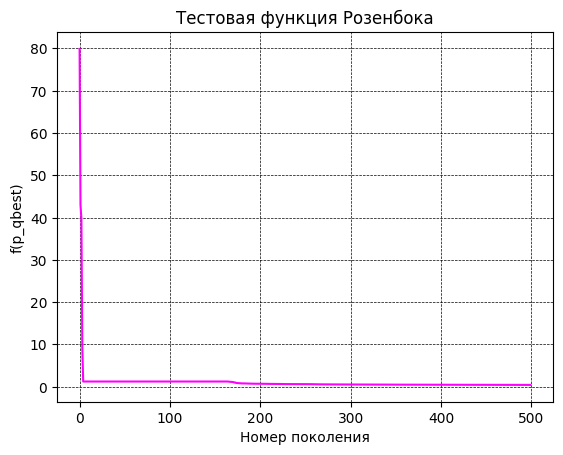

------------------------TEST NUMBER: 8------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[2.57012172 6.61121441]
The function value of pqbest:		2.468518399026128
Algorithm running time:			0.03997516632080078 s


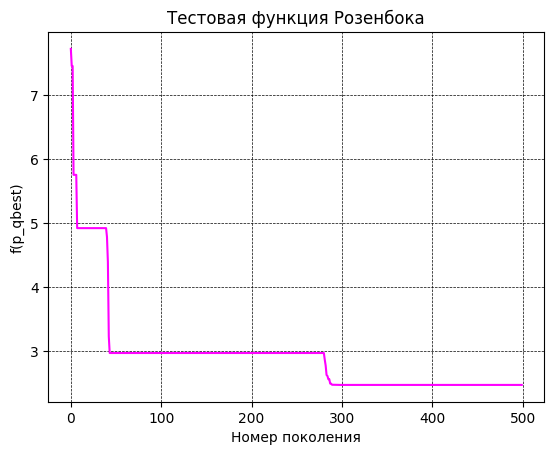

------------------------TEST NUMBER: 9------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.96534429 3.87977198]
The function value of pqbest:		0.9614522737947291
Algorithm running time:			0.039986371994018555 s


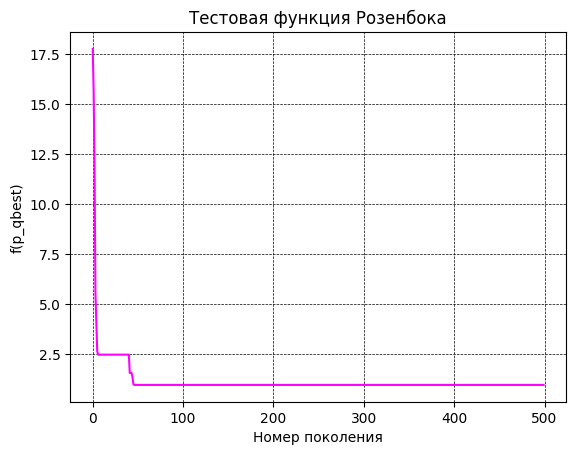

------------------------TEST NUMBER: 10------------------------
Theoretical value (Розенбока):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[-0.22389276  0.05099124]
The function value of pqbest:		1.4979880016416809
Algorithm running time:			0.03997659683227539 s


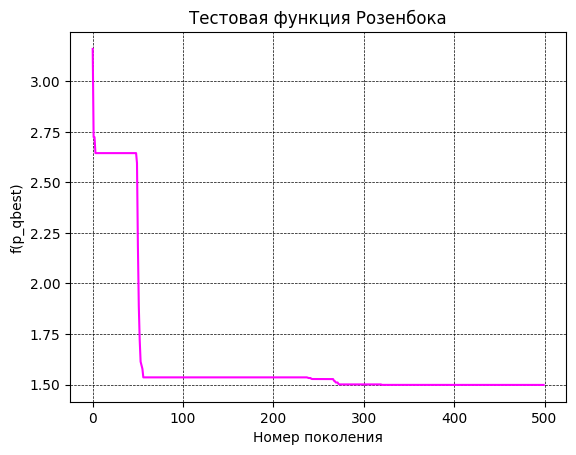

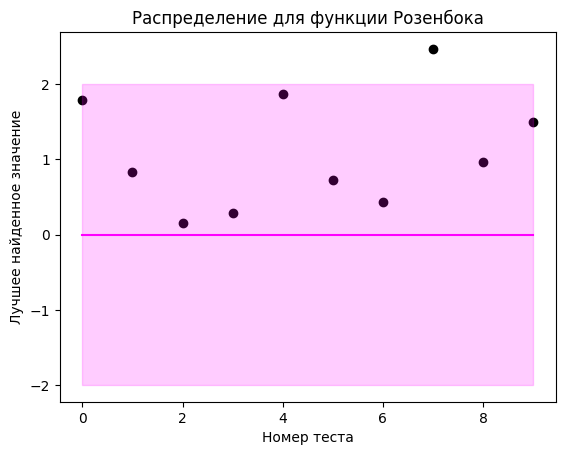

In [219]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(1, 1..., 1)")


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [220]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [221]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.99700363 0.50013167]
The function value of pqbest:		1.9076621342981405e-05
Algorithm running time:			3.610332489013672 s


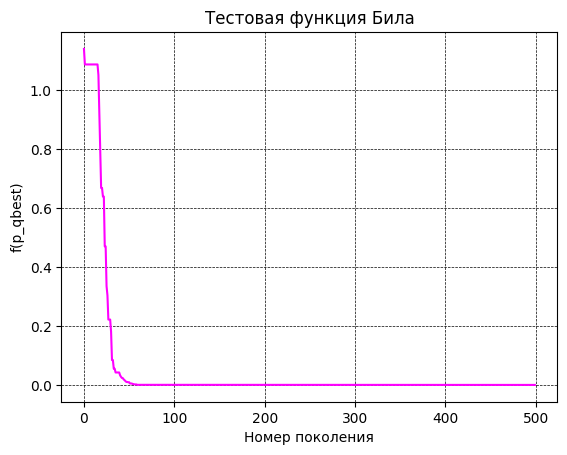

------------------------TEST NUMBER: 2------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.27461975 0.56201236]
The function value of pqbest:		0.009085899956711933
Algorithm running time:			0.03999495506286621 s


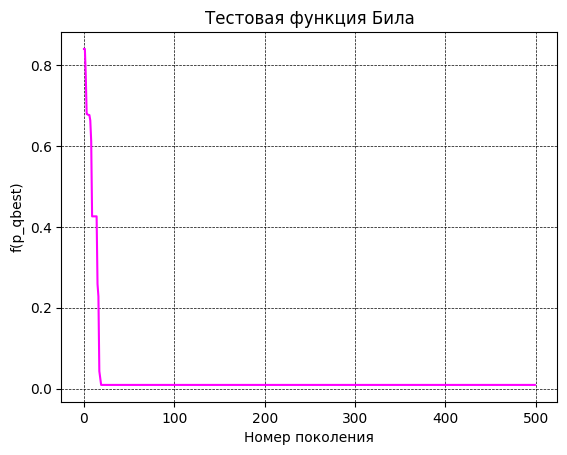

------------------------TEST NUMBER: 3------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.98980338 0.4574471 ]
The function value of pqbest:		0.034127144553573414
Algorithm running time:			0.04231524467468262 s


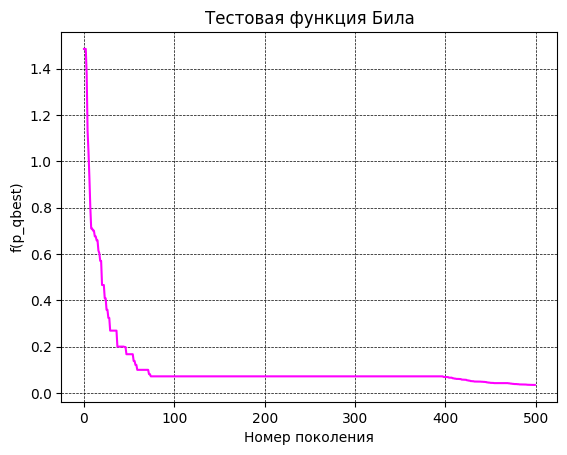

------------------------TEST NUMBER: 4------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.47324678 0.59435267]
The function value of pqbest:		0.0224739320138984
Algorithm running time:			0.04001569747924805 s


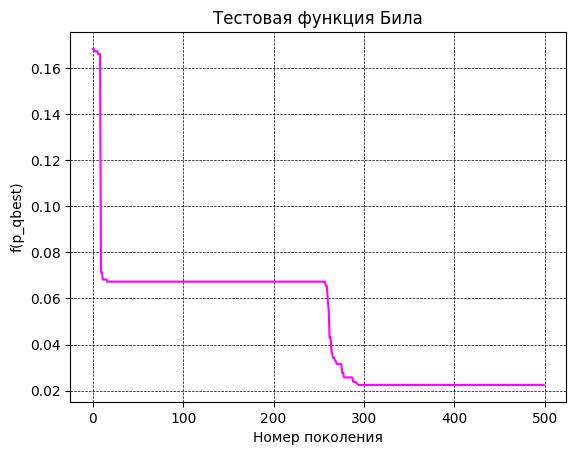

------------------------TEST NUMBER: 5------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.85124024 0.48881399]
The function value of pqbest:		0.019611256720857152
Algorithm running time:			0.04798269271850586 s


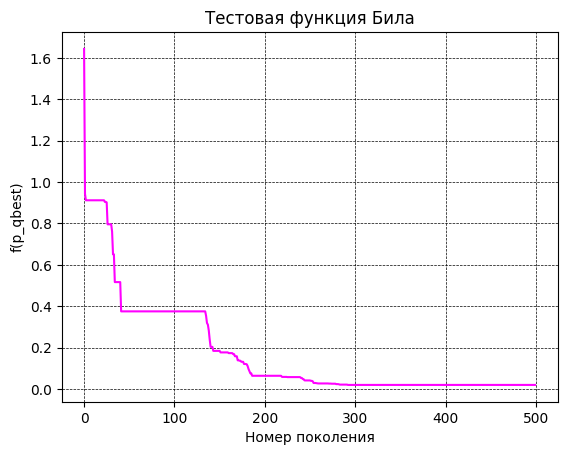

------------------------TEST NUMBER: 6------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.40068443 0.57771856]
The function value of pqbest:		0.01872847221761327
Algorithm running time:			0.0482029914855957 s


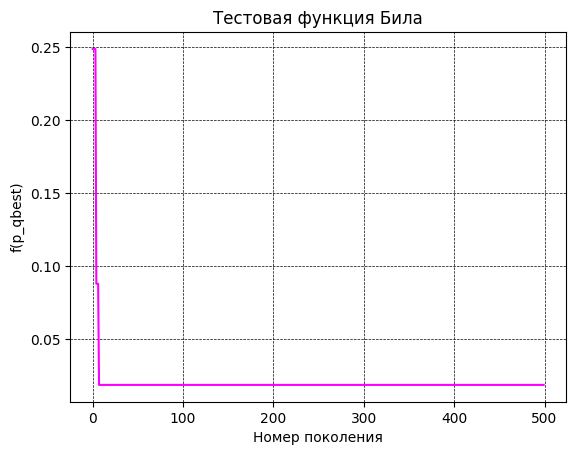

------------------------TEST NUMBER: 7------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.48176496 0.59741835]
The function value of pqbest:		0.02286335567528012
Algorithm running time:			0.039997100830078125 s


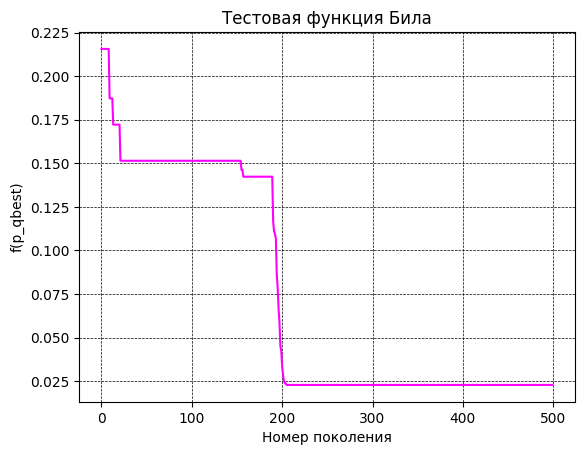

------------------------TEST NUMBER: 8------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.94145098 0.48103899]
The function value of pqbest:		0.0009391561462971467
Algorithm running time:			0.04000282287597656 s


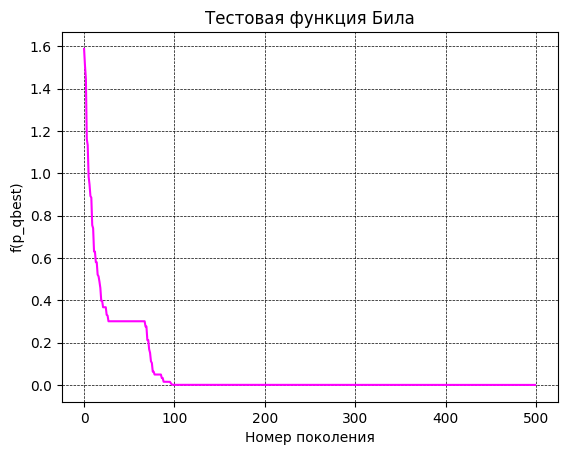

------------------------TEST NUMBER: 9------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.35902127 0.57613484]
The function value of pqbest:		0.014245993100212365
Algorithm running time:			0.03974723815917969 s


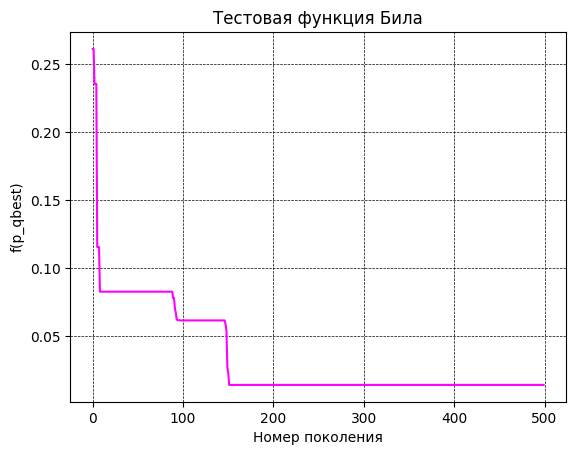

------------------------TEST NUMBER: 10------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[4.52798753 0.72174865]
The function value of pqbest:		0.10439040107574638
Algorithm running time:			0.040018558502197266 s


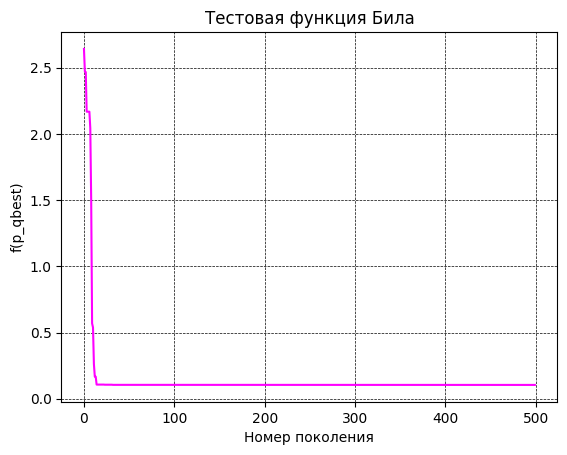

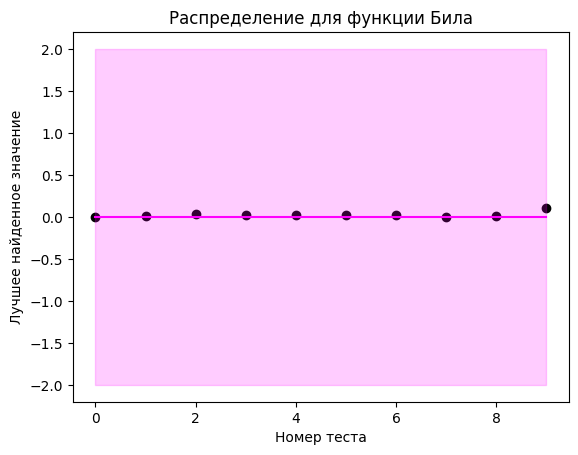

In [222]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(3, 0.5)")

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [223]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [224]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.03044385 -0.96783863]
The function value of pqbest:		3.4595231433416247
Algorithm running time:			3.7921206951141357 s


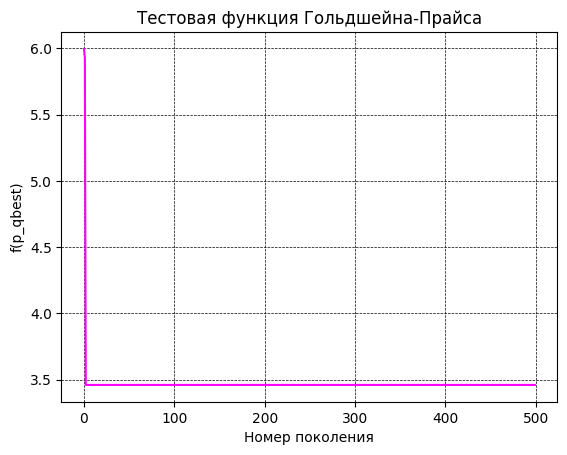

------------------------TEST NUMBER: 2------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.05140101 -0.91884053]
The function value of pqbest:		5.804917890200382
Algorithm running time:			0.03199601173400879 s


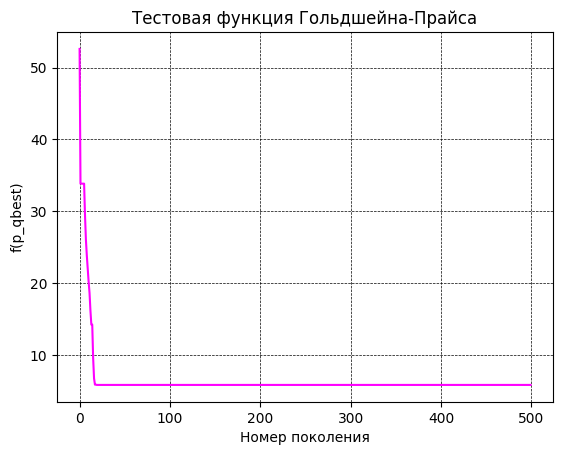

------------------------TEST NUMBER: 3------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.11808735 -0.92605624]
The function value of pqbest:		6.586310510835521
Algorithm running time:			0.04819321632385254 s


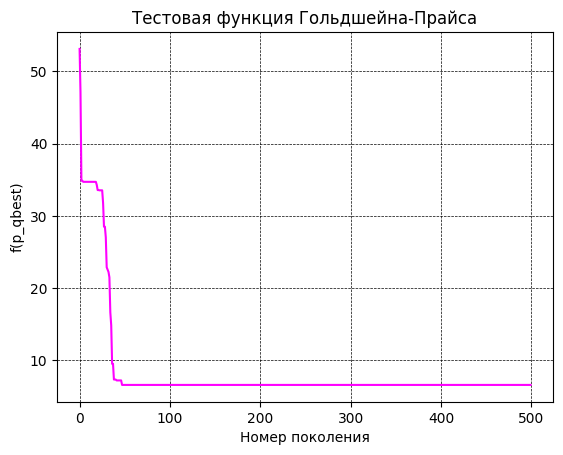

------------------------TEST NUMBER: 4------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.01423927 -0.97231447]
The function value of pqbest:		3.4426553022618194
Algorithm running time:			0.047158002853393555 s


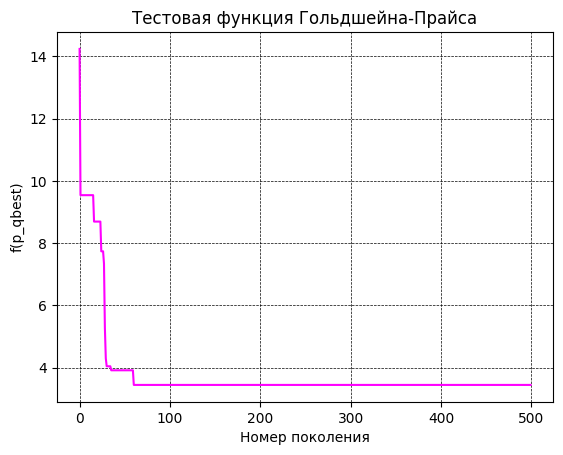

------------------------TEST NUMBER: 5------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.03283377 -1.00190527]
The function value of pqbest:		3.2635249746306525
Algorithm running time:			0.039989471435546875 s


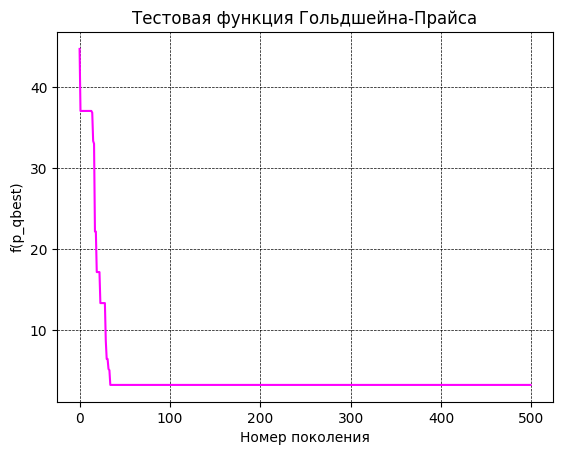

------------------------TEST NUMBER: 6------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.01409038 -1.00764232]
The function value of pqbest:		3.0526352581575624
Algorithm running time:			0.040007591247558594 s


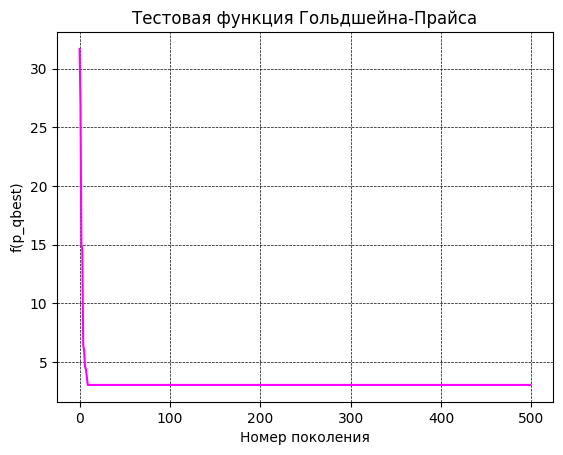

------------------------TEST NUMBER: 7------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.00244733 -0.99142303]
The function value of pqbest:		3.0372822717058985
Algorithm running time:			0.040008544921875 s


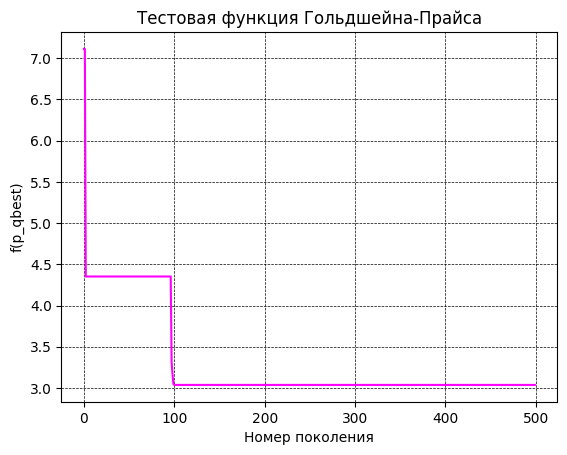

------------------------TEST NUMBER: 8------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.00913315 -0.99739189]
The function value of pqbest:		3.018759134380866
Algorithm running time:			0.03999757766723633 s


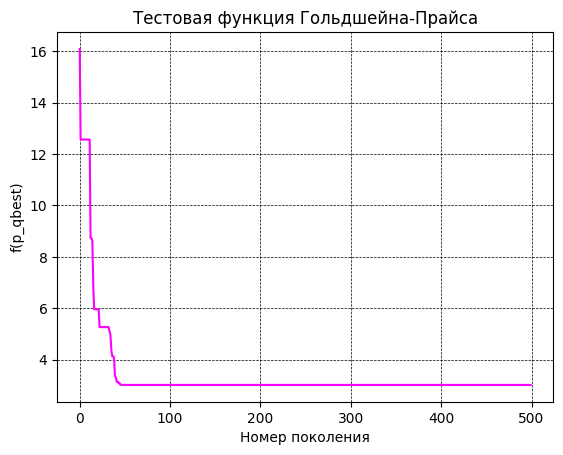

------------------------TEST NUMBER: 9------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.00561184 -0.97128271]
The function value of pqbest:		3.3267213929820785
Algorithm running time:			0.03999137878417969 s


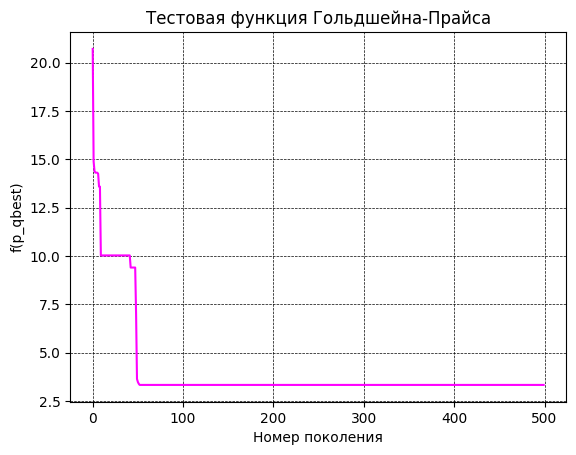

------------------------TEST NUMBER: 10------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.05167978 -0.90636451]
The function value of pqbest:		7.694934718381525
Algorithm running time:			0.048006296157836914 s


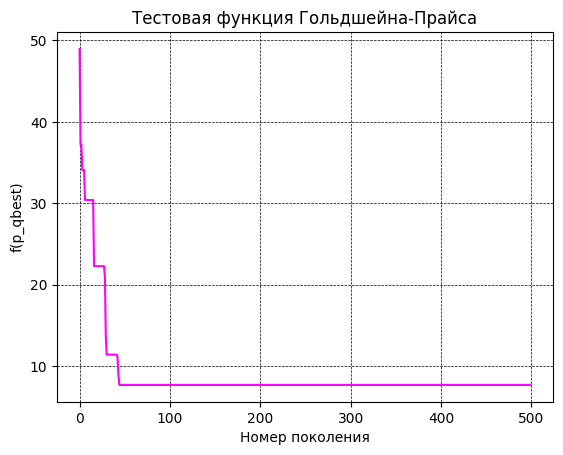

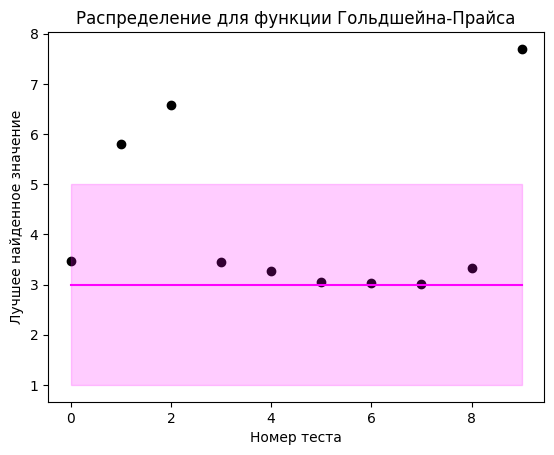

In [225]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3, st="f(0, -1)")

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [226]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [227]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.55096074 2.22088732]
The function value of pqbest:		0.11652250862893467
Algorithm running time:			4.039264678955078 s


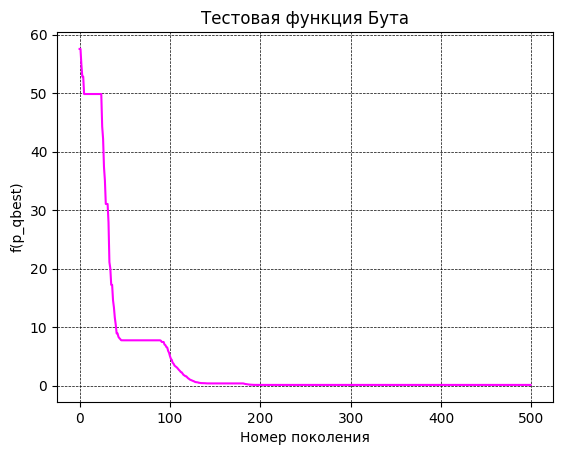

------------------------TEST NUMBER: 2------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.86588237 1.83768341]
The function value of pqbest:		0.34449141821761786
Algorithm running time:			0.041132211685180664 s


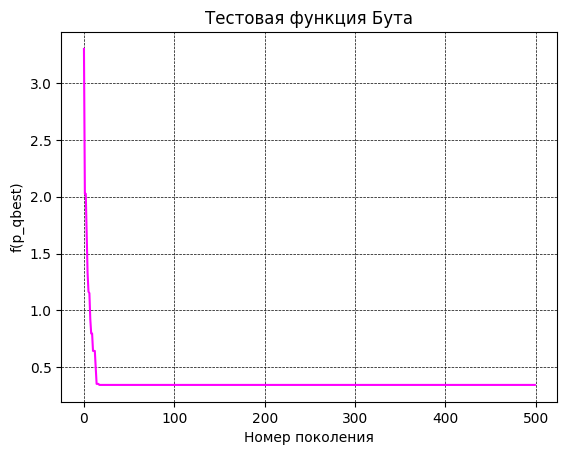

------------------------TEST NUMBER: 3------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.33821236 2.55366829]
The function value of pqbest:		0.08026657082712696
Algorithm running time:			0.0387265682220459 s


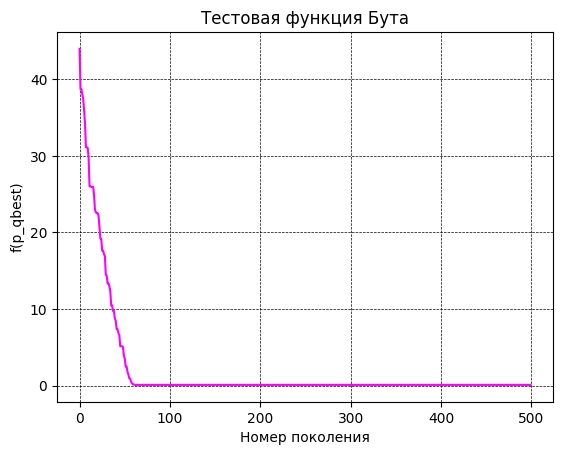

------------------------TEST NUMBER: 4------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.32780238 2.60340707]
The function value of pqbest:		0.07454859690195084
Algorithm running time:			0.04797530174255371 s


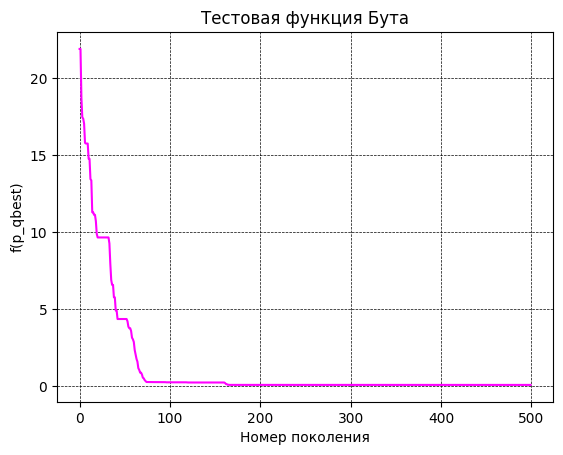

------------------------TEST NUMBER: 5------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.74937932 1.9464351 ]
The function value of pqbest:		0.23425696046789105
Algorithm running time:			0.039998531341552734 s


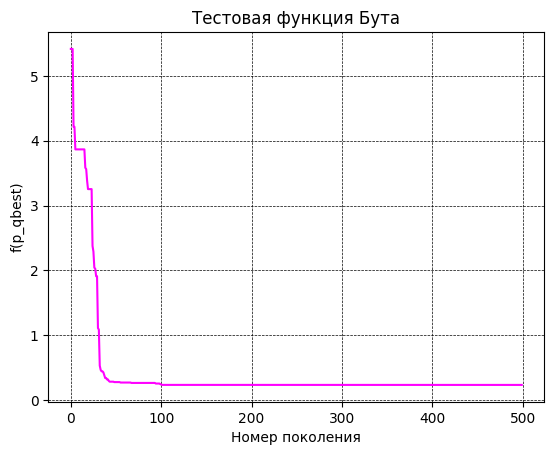

------------------------TEST NUMBER: 6------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.27135987 1.5949788 ]
The function value of pqbest:		9.41314894605153
Algorithm running time:			0.03999948501586914 s


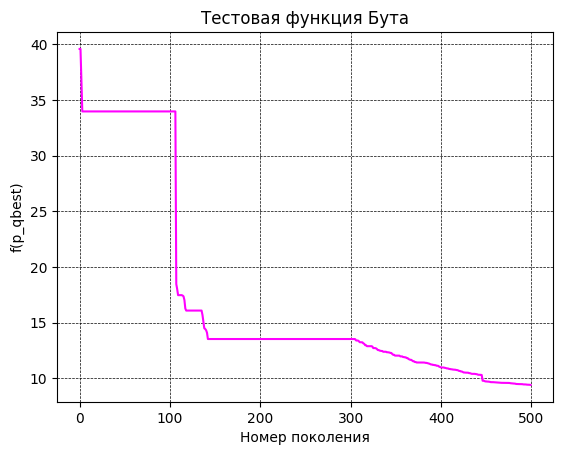

------------------------TEST NUMBER: 7------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.30304313 2.64988242]
The function value of pqbest:		0.07438942957630063
Algorithm running time:			0.04000282287597656 s


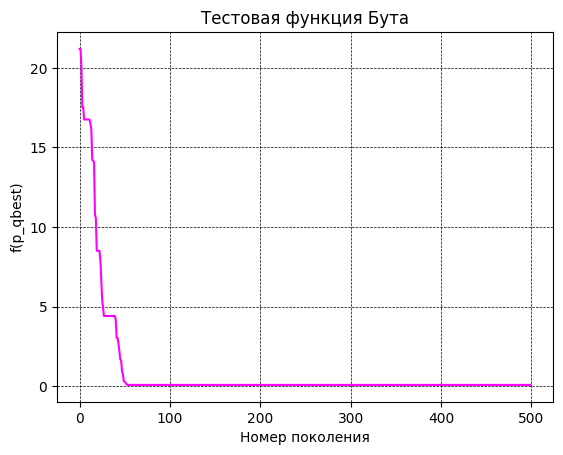

------------------------TEST NUMBER: 8------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.47490056 2.34679375]
The function value of pqbest:		0.0939631752032951
Algorithm running time:			0.04001641273498535 s


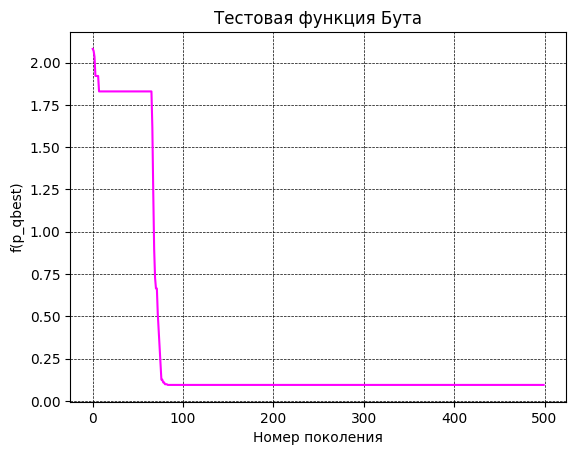

------------------------TEST NUMBER: 9------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[2.59037216 1.06888678]
The function value of pqbest:		3.7001064723493697
Algorithm running time:			0.039997100830078125 s


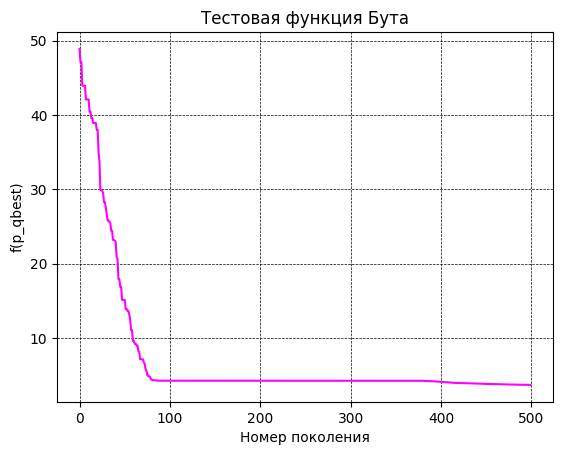

------------------------TEST NUMBER: 10------------------------
Theoretical value (Бута):f(1, 3)= 0

Coordinates of p_qbest:			[1.28676029 2.68426713]
The function value of pqbest:		0.0749154310092004
Algorithm running time:			0.039992332458496094 s


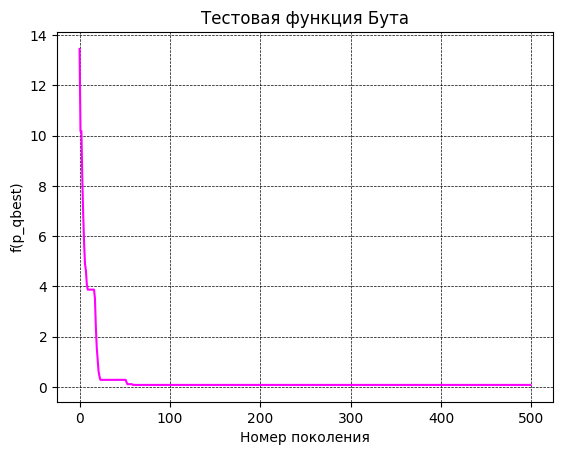

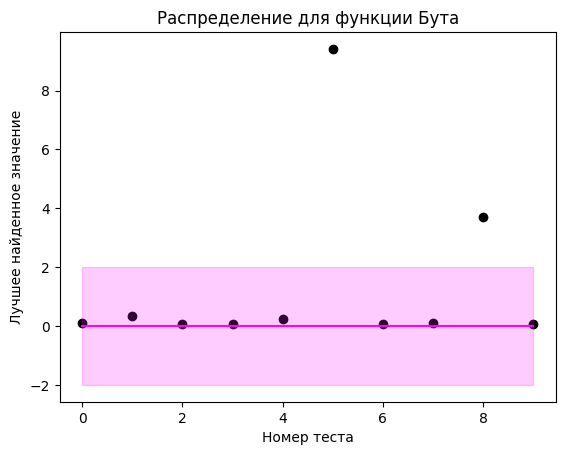

------------------------TEST NUMBER: 1------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.00736198 3.39267513]
The function value of pqbest:		0.1930988324202132
Algorithm running time:			3.6065454483032227 s


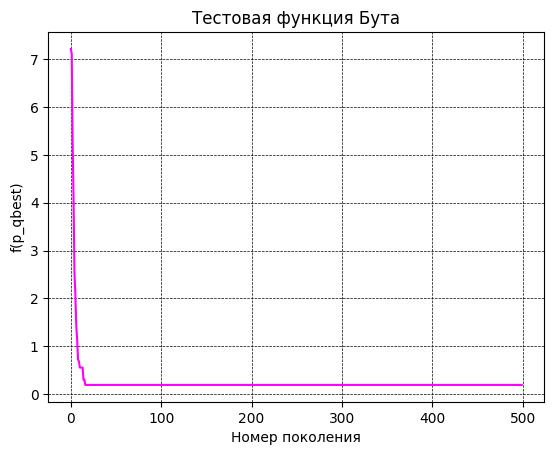

------------------------TEST NUMBER: 2------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.31758805 2.62386829]
The function value of pqbest:		0.07443906102478424
Algorithm running time:			0.04000663757324219 s


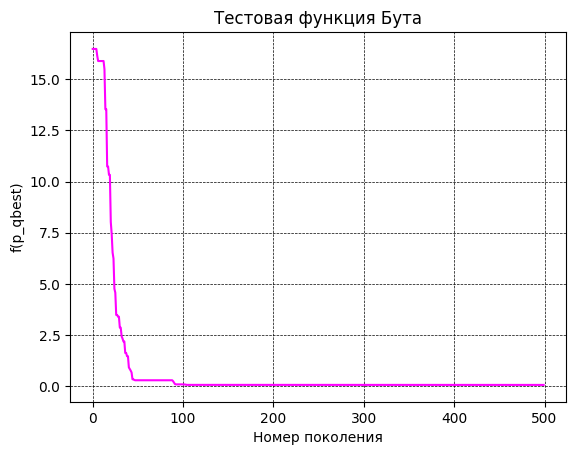

------------------------TEST NUMBER: 3------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.91160402 3.77951575]
The function value of pqbest:		0.37519110809580847
Algorithm running time:			0.03999733924865723 s


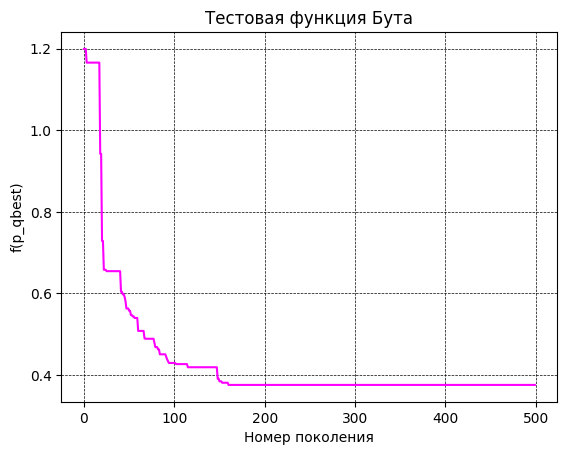

------------------------TEST NUMBER: 4------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[2.78251395 1.15653407]
The function value of pqbest:		3.2817088061059385
Algorithm running time:			0.040233612060546875 s


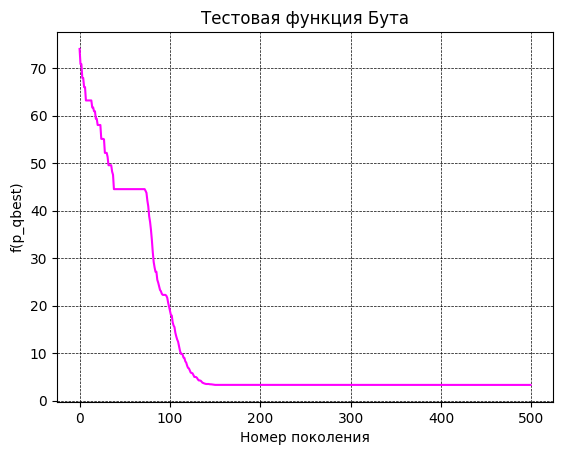

------------------------TEST NUMBER: 5------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[2.94648751 0.96513348]
The function value of pqbest:		5.175203750389799
Algorithm running time:			0.039812326431274414 s


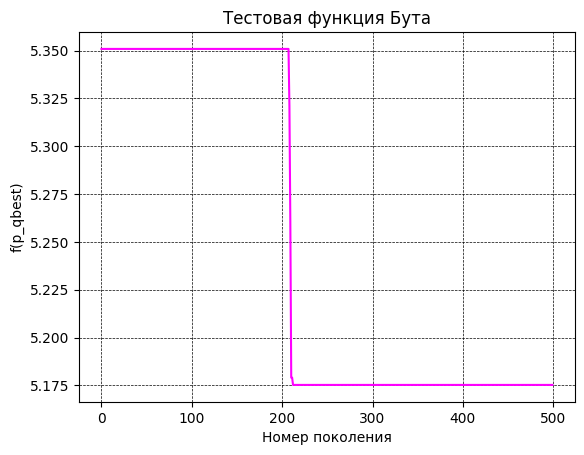

------------------------TEST NUMBER: 6------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.66457463 4.95128041]
The function value of pqbest:		1.8150689272595006
Algorithm running time:			0.0403749942779541 s


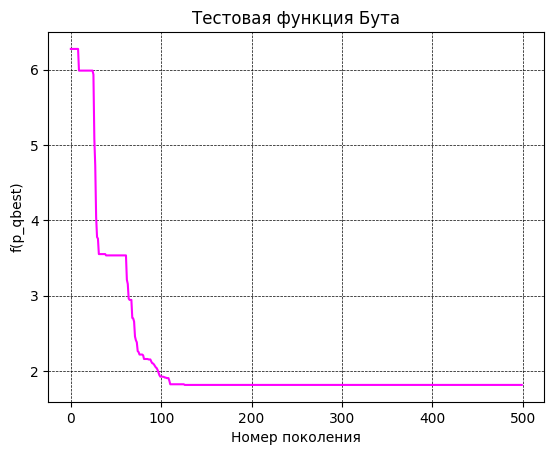

------------------------TEST NUMBER: 7------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[2.45169582 1.29601442]
The function value of pqbest:		1.8547724199772406
Algorithm running time:			0.04003143310546875 s


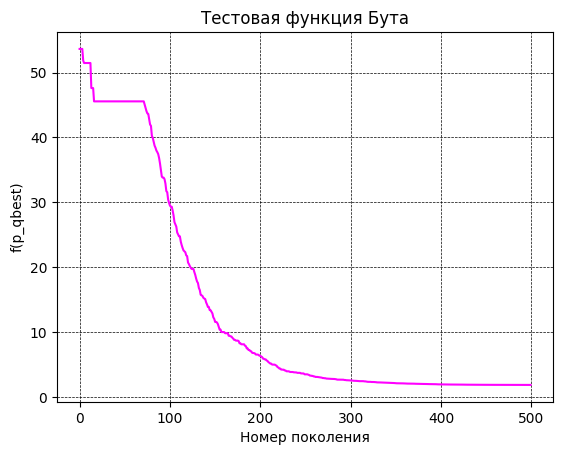

------------------------TEST NUMBER: 8------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.2665526 2.7239275]
The function value of pqbest:		0.07606682589781874
Algorithm running time:			0.03998517990112305 s


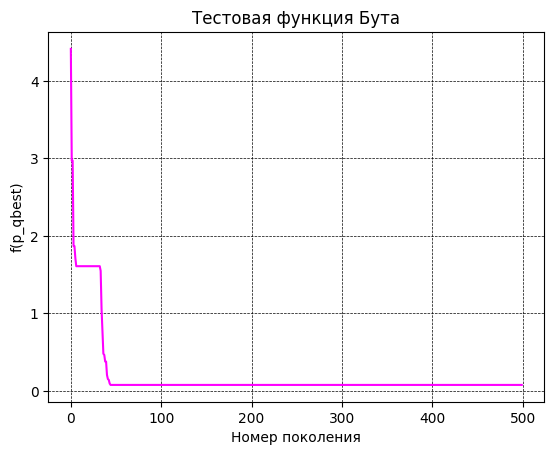

------------------------TEST NUMBER: 9------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.64557839 2.09858373]
The function value of pqbest:		0.16058985548132718
Algorithm running time:			0.04131126403808594 s


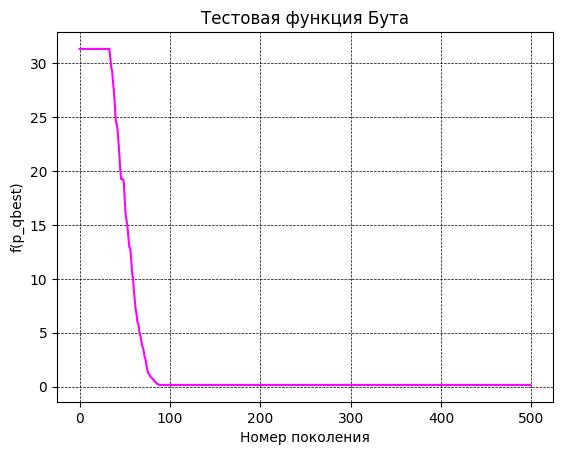

------------------------TEST NUMBER: 10------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.40819108 7.22531526]
The function value of pqbest:		10.464964405425889
Algorithm running time:			0.03999757766723633 s


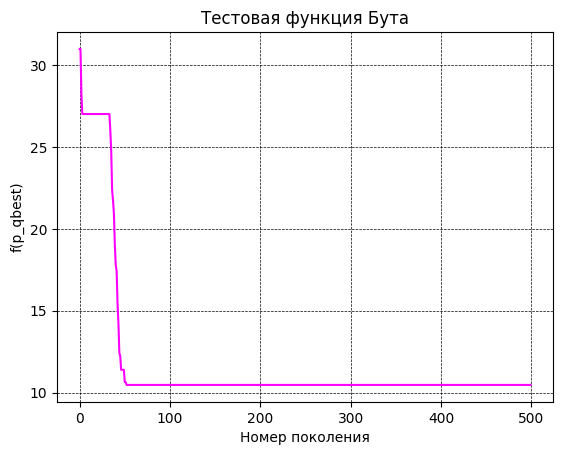

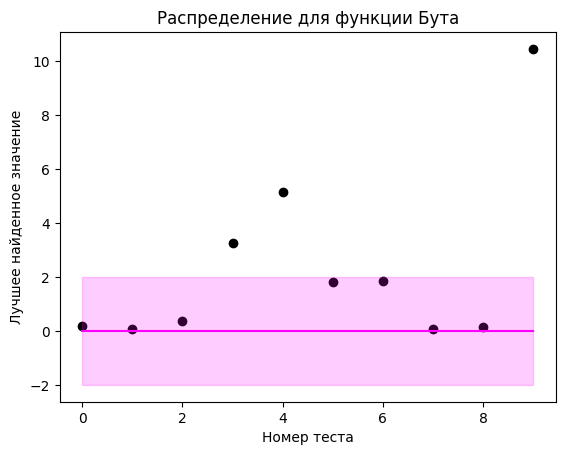

In [228]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(1, 3)")

## Реализация алгоритма на C. Сравнение двух реализаций

In [229]:
import ctypes
import os


class Result(ctypes.Structure):
    _fields_ = [
        ("best_solution", ctypes.POINTER(ctypes.c_float)),
        ("best_y", ctypes.c_float),
        ("time_spent", ctypes.c_double)
    ]


def c(file, name, types, result):
    path = os.path.abspath(file)
    module = ctypes.cdll.LoadLibrary(path)
    func = module[name]
    func.argtypes = types
    func.restype = result
    return func


test_Rastrigen = c("libcode.dll", "test_Rastrigen", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Ekli = c("libcode.dll", "test_Ekli", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Sphere = c("libcode.dll", "test_Sphere", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Rosenbock = c("libcode.dll", "test_Rosenbock", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Bila = c("libcode.dll", "test_Bila", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Goldsheina_Praisa = c("libcode.dll", "test_Goldsheina_Praisa", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Buta = c("libcode.dll", "test_Buta", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)


## Сравнение реализаций по скорости выполнения

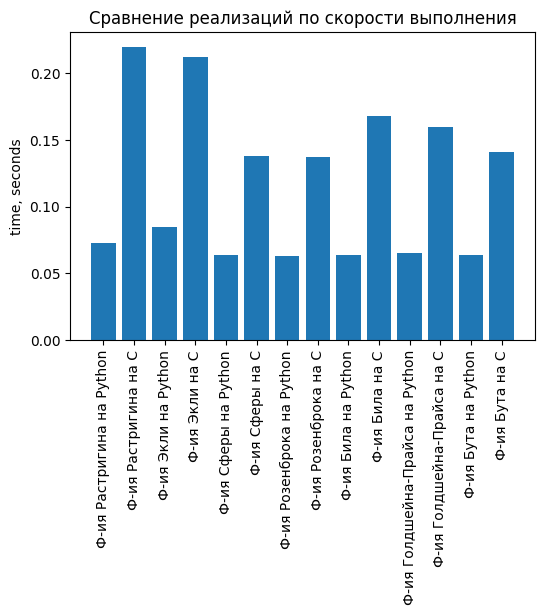

In [233]:
time_on_c = list()
time_on_c.append(test_Rastrigen(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Ekli(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Sphere(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Rosenbock(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Bila(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Goldsheina_Praisa(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Buta(number_of_agents_, n_args_count_, iter_max_).time_spent)

time_on_python = list()
start = time.time()
main_function(f1, generate_agents1, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f2, generate_agents2, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f3, generate_agents3, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f4, generate_agents4, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f5, generate_agents5, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f6, generate_agents6, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f7, generate_agents7, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)

plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

list_to_draw = list()
for i in range(7):
    list_to_draw.append(time_on_python[i])
    list_to_draw.append(time_on_c[i])

list_of_title = ['Ф-ия Растригина на Python', 'Ф-ия Растригина на C',
                 'Ф-ия Экли на Python', 'Ф-ия Экли на C',
                 'Ф-ия Сферы на Python', 'Ф-ия Сферы на C',
                 'Ф-ия Розенброка на Python', 'Ф-ия Розенброка на С',
                 'Ф-ия Била на Python', 'Ф-ия Била на C',
                 'Ф-ия Голдшейна-Прайса на Python', 'Ф-ия Голдшейна-Прайса на C',
                 'Ф-ия Бута на Python', 'Ф-ия Бута на C']

ax.bar(list_of_title, list_to_draw)

plt.ylabel("time, seconds")
plt.title("Сравнение реализаций по скорости выполнения")
plt.xticks(rotation=90)
plt.show()

## Тестирование алгоритма в n-мерном пространстве

### Тестирование алгоритма в 100-мерном пространстве

In [97]:
start = time.time()
res = main_function(f3, generate_agents3, 100, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 7.83839999808262
Time is 8.546939849853516
Coordinates: [-0.01461523  0.40158649  0.29920827  0.30797507  0.34206651 -0.04727888
  0.09802692  0.19218935  0.07653566  0.23741665  0.35784918  0.3228778
  0.27096489  0.270692    0.25549173  0.27041753  0.35627098  0.36671147
  0.27289764  0.2192784   0.45376702  0.28108338  0.31843085  0.31257644
  0.0883634   0.30700201  0.13706985  0.29467947  0.23952454  0.21272725
  0.31801226  0.29503359  0.26212068  0.23302186  0.36577441  0.32642406
 -0.13128564  0.33567763  0.30697849  0.26504323  0.28867557  0.30999928
  0.28652184  0.27279779  0.22347787  0.19455194  0.29695399  0.24264899
  0.28002313 -0.14555896  0.22976996  0.28262078  0.25661435  0.23432025
  0.22668165  0.37574783  0.34671453  0.24648158  0.18093782  0.26043426
  0.46004987  0.29312847  0.20543473  0.32597006  0.05233861  0.22697023
  0.11470339  0.32749406  0.26887365  0.24685598  0.29681687 -0.07245868
  0.2893826  -0.

### Тестирование алгоритма в 50-мерном пространстве

In [101]:
start = time.time()
res = main_function(f3, generate_agents3, 50, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 4.011107057377971
Time is 7.233178615570068
Coordinates: [ 0.26751926  0.36184321  0.08937083  0.30431897  0.06145001  0.21911876
 -0.05789606  0.06782827  0.2829966   0.3084018   0.04798901  0.23651979
 -0.04983506  0.14379761  0.31060685  0.28856066  0.12289851  0.27201303
  0.10605441  0.26878344  0.35632883  0.41057165  0.28069547  0.03132403
  0.32765322  0.38909472  0.37330137  0.24458449  0.7508708   0.08396954
  0.25386361  0.43418145  0.19761023  0.28513771 -0.20811839  0.32759267
 -0.23136397  0.27151275  0.24562856  0.31652302  0.3053794   0.3888473
  0.18432334  0.0922668   0.20388972  0.18155134  0.62805986  0.01524695
  0.10535608  0.23718616]


### Тестирование алгоритма в 10-мерном пространстве

In [99]:
start = time.time()
res = main_function(f3, generate_agents3, 10, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 0.1497749230017234
Time is 5.715345144271851
Coordinates: [ 0.01720229  0.09220778 -0.06618106  0.11334128  0.04333773  0.25308036
  0.14630737  0.09779017  0.15358089 -0.05715654]
